In [65]:
%matplotlib inline
import pandas as pd
import seaborn as sns
from datetime import datetime


Вводные

Водитель может находиться в 4 возможных статусах:
    * free -- доступен для нового заказа
    * enroute -- едет на заказ
    * ontrip -- выполняет заказ
    * busy -- недоступен для нового заказа

Возможные переходы из одного состояние в другое определены как:
    * free -> [free, enroute, busy]
    * enroute -> [free, ontrip]
    * ontrip -> [free]
    * busy -> [free]

Почему переходы определяются таким образом:
1. Из состояния free можно перейти в
    * free -- если водитель ушел в офлайн и заново вышел на линию, тогда подряд будет две записи со статусом free
    * enroute -- если водитель принял заказ, то переходит в статус enroute и едет к клиенту
    * busy -- если водитель нажал кнопку "Занят" в таксометре (пошел на обед и т.д.)
2. Из состояния enroute можно перейти в 
    * free -- если клиент или водитель отменил заказ
    * ontrip -- если водитель приехал к клиенту и начал выполнять заказ
3. Из состояния ontrip можно перейти только в free (после выполнения заказа)
4. Из состояния busy можно перейти только в free

Эффективность на поездке -- это время с клиентом в машине (ontrip), деленное на сумму длительностей всех статусов, связанных с поездкой (sum(free) + enroute + ontrip), где sum(free) -- время простоя.

Время простоя -- это сумма всех статусов free, предшествующих поездке. Суммируются все статусы free, идущие подряд, а также те, которые были прерваны короткими статусами busy или enroute (короткий статус == меньше какого-то TIMEOUT'а).

Имеется набор данных со статусами водителей, по которому необходимо построить зависимость длительности поездки от эффективности.
    * driver_id -- id водителя
    * status -- один из статусов
    * dttm -- время начала статуса

Примечания:
    * Поездка считается только при наличии статуса ontrip
    * Тесты написаны для python 2

    1. Написать функцию-генератор, которая будет отдавать соседние элементы в цикле. Функция понадобится для итерирования по записям водителя и проверки соседних статусов по условиям. Не забудьте проверить, что тесты проходят без ошибок (см. test_neighbors).

In [86]:
def neighbors(iterable):
    """Make an iterator that yields an (previous, current, next) tuple per element.
 
    Returns None if the value does not make sense (i.e. previous before
    first and next after last).
    """
    iterable=iter(iterable)
    prv = None
    cur = iterable.next()
    try:
        while True:
            nxt = iterable.next()
            yield (prv,cur,nxt)
            prv = cur
            cur = nxt
    except StopIteration:
        yield (prv,cur,None)
        

In [87]:
# Check if test passes
def test_neighbors():
    test_neighbors = neighbors( range(2) )
    assert test_neighbors.next() == (None, 0, 1)

test_neighbors()
    

    2. Сгруппировать данные на уровне водителя таким образом, чтобы в одной строке находились все его записи со статусами и началом статуса списком:

Формат исходной таблицы:
<table>
<tr><td>driver_id</td><td>status</td><td>dttm</td></tr>
<tr><td>9f8f9bf3ee8f4874873288c246bd2d05</td><td>free</td><td>2018-02-04 00:19</td></tr>
<tr><td>9f8f9bf3ee8f4874873288c246bd2d05</td><td>busy</td><td>2018-02-04 01:03</td></tr>
<tr><td>8f174ffd446c456eaf3cca0915d0368d</td><td>free</td><td>2018-02-03 15:43</td></tr>
<tr><td>8f174ffd446c456eaf3cca0915d0368d</td><td>enroute</td><td>2018-02-03 17:02</td></tr>
<tr><td>...</td><td>...</td><td>...</td></tr>
</table>

Формат сгруппированной таблицы:
<table>
<tr><td>driver_id</td><td>driver_info</td></tr>
<tr><td>9f8f9bf3ee8f4874873288c246bd2d05</td><td>[("free", 2018-02-04 00:19), ("busy", 2018-02-04 01:03)]</td></tr>
<tr><td>8f174ffd446c456eaf3cca0915d0368d</td><td>[("free", 2018-02-03 15:43), ("enroute", 2018-02-03 17:02) ...]</td></tr>
</table>

In [97]:
df = pd.read_csv("./dataset.csv", parse_dates=["dttm"])

# ... type your code here ...

df['dttm'] = df['dttm'].astype('datetime64[s]')
df['driver_info'] = df[['status','dttm']].apply(tuple, axis=1)
del df['status']
del df['dttm']
df = df.groupby('driver_id')['driver_info'].apply(lambda x :x.values.tolist()).reset_index()


    3. Используя функцию neighbors, написать функцию, которая для каждой записи в списке driver_info посчитает ее длительность.


In [98]:
def calc_status_duration(driver_info):
    driver_info_updated = []
    for i, j, k in neighbors(driver_info):
        if i is None:
            driver_info_updated.append ((j[0],j[1], (k[1]-j[1]).total_seconds()))
        elif k is None:
            driver_info_updated.append ((j[0],j[1], None))
        else:
            driver_info_updated.append ((j[0],j[1], (k[1]-j[1]).total_seconds()))
    return driver_info_updated


In [99]:
# Check if test passes
def test_calc_status_duration():
    sample_driver_info = [("free", datetime(2018, 4, 2, 0, 19)), 
                          ("busy", datetime(2018, 4, 2, 1, 3)),]
    sample_driver_info_updated = [('free', datetime(2018, 4, 2, 0, 19), 2640.0),
                                  ('busy', datetime(2018, 4, 2, 1, 3), None),]
    assert calc_status_duration(sample_driver_info) == sample_driver_info_updated

test_calc_status_duration()

In [100]:
df["driver_info"] = df.driver_info.apply(calc_status_duration)

    4. Используя функцию neighbors, написать функцию, которая сформирует из списка driver_info список поездок с информацией о длительности поездки и эффективности (duration_ontrip, efficiency).

Эффективность на поездке -- это время с клиентом в машине (ontrip), деленное на сумму длительностей всех статусов, связанных с поездкой (sum(free) + enroute + ontrip), где sum(free) -- время простоя.

Время простоя -- это сумма всех статусов free, предшествующих поездке. Суммируются все статусы free, идущие подряд, а также те, которые были прерваны короткими статусами busy или enroute (короткий статус == меньше какого-то TIMEOUT'а).

In [101]:
TIMEOUT = 1600

def collapse_statuses(driver_info):
    collapsed_statuses = []
    trip_time = 0
    downtime = 0
    for i, j, k in neighbors(driver_info):
        if i is not None and i[0] == 'free' and j[0] == 'enroute' and k is not None and k[0] == 'ontrip' and k[2] is not None:
            trip_time += (i[2] + j[2] + k[2])
            collapsed_statuses.append((k[2], k[2] / (trip_time + downtime)))
            downtime = 0
            trip_time = 0
        if i is not None and i[0] == 'free' and (j[0] in ['enroute', 'busy']) and j[2] < TIMEOUT:
            downtime += i[2]
    return collapsed_statuses        
    # Here define conditions under which the "free" state 
    # should be attributed to the trip.
    # ... type your code here ...


In [102]:
# Check if test passes
def test_collapse_statuses():
    sample_driver_info = [("free", datetime(2018, 4, 2, 0, 19), 2640.0), 
                          ("busy", datetime(2018, 4, 2, 1, 3), 1660.0),
                          ("free", datetime(2018, 4, 2, 1, 30, 40), 2050.0),
                          ("enroute", datetime(2018, 4, 2, 2, 4, 50), 70.0),
                          ("free", datetime(2018, 4, 2, 2, 6), 500.0),
                          ("enroute", datetime(2018, 4, 2, 2, 14, 20), 520.0),
                          ("ontrip", datetime(2018, 4, 2, 2, 23), 3060.0),
                          ("free", datetime(2018, 4, 2, 3, 14), None)]
    sample_driver_info_updated = [(3060.0, 3060.0 / (3060.0 + 520.0 + 500.0 + 2050.0))]
    assert collapse_statuses(sample_driver_info) == sample_driver_info_updated

test_collapse_statuses()


In [103]:
df["driver_info"] = df.driver_info.apply(collapse_statuses)
df.head()


,driver_id,driver_info
0,029e9b80b45c483fbb00c4695c2d9c09,"[(4561.0, 0.41082687804), (3622.0, 0.175492998..."
1,041ddc65a16649129eb6dbee9b54d6e8,"[(2985.0, 0.298023162939), (5845.0, 0.55804850..."
2,048459e02e63450d9429ceb34601929d,"[(1116.0, 0.201407688143), (5261.0, 0.29941380..."
3,0f8eccff510f4bdabbff9f40b2262517,"[(2780.0, 0.236013243909), (3580.0, 0.18789691..."
4,14637bc848b24ac49fbadc43d207e375,"[(4526.0, 0.439502816081), (149.0, 0.011585413..."


    5. Нарисовать и проинтерпретировать зависимость между длительностью поездки и эффективностью.
    Подсказка: требуется сделать обратное преобразование из таблицы со строками на уровне водителя в таблицу со строками на уровне поездки.

In [104]:
s = df.apply(lambda x: pd.Series(x['driver_info']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'driver_info'
df = df.drop('driver_info', axis=1).join(s)
df['driver_info'] = pd.Series(df['driver_info'], dtype=object)

In [105]:
res = df['driver_info'].apply(pd.Series)
res.columns = ['trip_time', 'efficiency']
result = pd.concat([df, res], axis=1, sort=False)
del result['driver_info']

In [106]:
result.head()

,driver_id,trip_time,efficiency
0,029e9b80b45c483fbb00c4695c2d9c09,4561.0,0.410827
0,029e9b80b45c483fbb00c4695c2d9c09,3622.0,0.175493
1,041ddc65a16649129eb6dbee9b54d6e8,2985.0,0.298023
1,041ddc65a16649129eb6dbee9b54d6e8,5845.0,0.558049
1,041ddc65a16649129eb6dbee9b54d6e8,1074.0,0.124840


График зависимости длительности поездки от эффективности

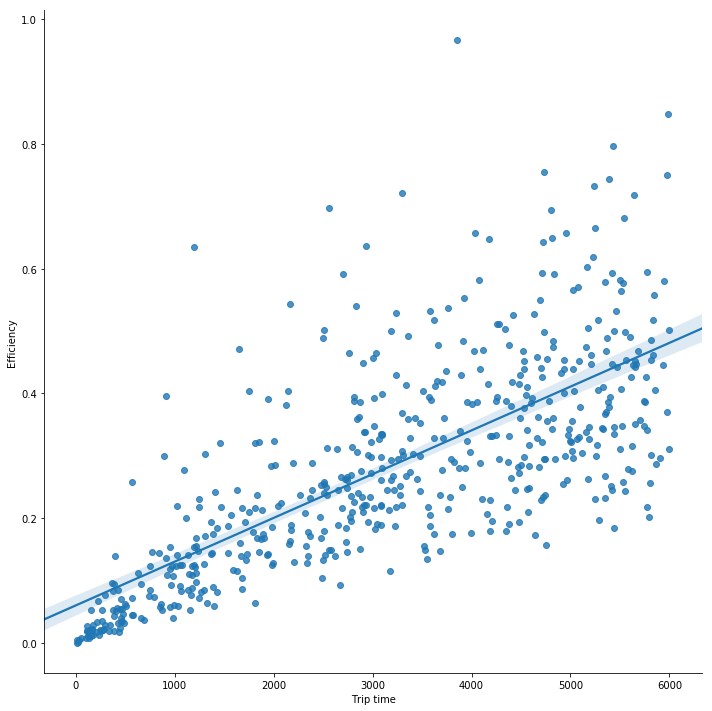

In [107]:
plot = sns.lmplot(x='trip_time', y='efficiency', data=result, height=10)
plot.set_axis_labels(x_var='Trip time', y_var='Efficiency')